In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, auc
from sklearn.metrics import roc_auc_score,precision_score, recall_score, f1_score,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from tqdm import tqdm

In [2]:
df  = pd.read_csv('dataset/pre_process_all_news_days.csv', encoding = "ISO-8859-1", parse_dates=["Date"])

In [3]:
#Get the name of the headline columns
cols = []
for i in range(1,26):
    col = ("Top{}".format(i))
    cols.append(col)

In [4]:
for col in tqdm(cols):
    df[col] = df[col].apply(lambda x: literal_eval(x))

100%|██████████| 25/25 [00:02<00:00,  9.42it/s]


In [5]:
def Evaluation (Method,Comment,Actual, Predicted,Scores):
    ROC_AUC=roc_auc_score(Actual,Predicted)    
    Precision=precision_score(Actual,Predicted)
    Accuracy=accuracy_score(Actual,Predicted)
    Recall=recall_score(Actual,Predicted)
    F1=f1_score(Actual,Predicted)    
    Scores[Comment] = {'Method':Method,'ROC_AUC':ROC_AUC,'Accuracy':Accuracy,
                       'Precision':Precision,'Recall':Recall,'F1':F1}     
    

In [6]:
#Creating a Data Pipeline for Naive Bayes classifier classifier - baseline
rf_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=lambda x: x)),  
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', RandomForestClassifier()) # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [7]:
def headlines_analyze(lbl,sc):
    df_h = df[['Date',lbl]].copy()
    for cl in cols:    
        df_h['news'] = df[cl]
        train = df_h[df_h['Date']<'20141231']
        test = df_h[df_h['Date']>'20141231']
        y_train = train[lbl]
        y_test = test[lbl]

        rf_pipeline.fit(train['news'],y_train)
        predictions = rf_pipeline.predict(test['news'])    
        Evaluation ('RandomForestClassifier()',cl+'_'+lbl,y_test, predictions,sc)

In [8]:
sc={}
for i, lbl in enumerate(['Label','Label_1day','Label_2day', 'Label_3day', 'Label_4day', 'Label_5day']):
    headlines_analyze(lbl,sc)

In [9]:
df_sc = pd.DataFrame.from_dict(sc, orient='index')
df_sc.sort_values(by=['ROC_AUC','Accuracy'],ascending=False,inplace=True)
df_sc.head(10)

,Method,ROC_AUC,Accuracy,Precision,Recall,F1
Top25_Label,RandomForestClassifier(),0.578377,0.582011,0.561594,0.807292,0.662393
Top25_Label_1day,RandomForestClassifier(),0.567456,0.571429,0.627660,0.317204,0.421429
Top16_Label_3day,RandomForestClassifier(),0.559617,0.579365,0.628571,0.248588,0.356275
Top13_Label_5day,RandomForestClassifier(),0.558605,0.579365,0.640625,0.231638,0.340249
Top12_Label,RandomForestClassifier(),0.546623,0.550265,0.539855,0.776042,0.636752
Top24_Label,RandomForestClassifier(),0.545363,0.547619,0.543210,0.687500,0.606897
Top1_Label_3day,RandomForestClassifier(),0.543005,0.563492,0.590909,0.220339,0.320988
Top18_Label_4day,RandomForestClassifier(),0.538732,0.558201,0.555556,0.255682,0.350195
Top16_Label_4day,RandomForestClassifier(),0.538001,0.558201,0.558442,0.244318,0.339921
Top7_Label,RandomForestClassifier(),0.536710,0.539683,0.534615,0.723958,0.615044


In [12]:
def headlines_analyze_two(lbl,sc):
    df_h = df[['Date',lbl]].copy()
    for i in tqdm(range(1,26)):
        col1 = ("Top{}".format(i))
        for j in range(i+1,26):        
            col2 = ("Top{}".format(j))
            cls = col1+'+'+col2             
            df_h['news'] = df[col1]+ df[col2]
            train = df_h[df_h['Date']<'20141231']
            test = df_h[df_h['Date']>'20141231']
            y_train = train[lbl]
            y_test = test[lbl]
            rf_pipeline.fit(train['news'],y_train)
            predictions = rf_pipeline.predict(test['news'])                
            Evaluation ('RandomForestClassifier()',cls+'_'+lbl,y_test, predictions,sc)

In [13]:
sc_2c={}
for i, lbl in enumerate(['Label','Label_1day','Label_2day', 'Label_3day', 'Label_4day', 'Label_5day']):
    headlines_analyze_two(lbl,sc_2c)

100%|██████████| 25/25 [25:05<00:00, 60.20s/it]


In [14]:
df_sc2 = pd.DataFrame.from_dict(sc_2c, orient='index')
df_sc2.sort_values(by=['ROC_AUC','Accuracy'],ascending=False,inplace=True)
df_sc2.head(10)

,Method,ROC_AUC,Accuracy,Precision,Recall,F1
Top20+Top25_Label_1day,RandomForestClassifier(),0.572917,0.576720,0.632653,0.333333,0.436620
Top1+Top18_Label,RandomForestClassifier(),0.570481,0.574074,0.556364,0.796875,0.655246
Top10+Top16_Label_1day,RandomForestClassifier(),0.564768,0.568783,0.623656,0.311828,0.415771
Top2+Top6_Label_2day,RandomForestClassifier(),0.563056,0.589947,0.600000,0.280702,0.382470
Top11+Top13_Label,RandomForestClassifier(),0.562836,0.566138,0.552239,0.770833,0.643478
Top23+Top24_Label_4day,RandomForestClassifier(),0.561825,0.579365,0.593407,0.306818,0.404494
Top16+Top20_Label,RandomForestClassifier(),0.560064,0.563492,0.549815,0.776042,0.643629
Top9+Top20_Label,RandomForestClassifier(),0.558048,0.560847,0.550781,0.734375,0.629464
Top4+Top15_Label_3day,RandomForestClassifier(),0.557340,0.574074,0.590909,0.293785,0.392453
Top6+Top24_Label_1day,RandomForestClassifier(),0.557292,0.560847,0.596154,0.333333,0.427586


In [15]:
def headlines_analyze_three(lbl,sc):
    df_h = df[['Date',lbl]].copy()
    for i in tqdm(range(1,26)):
        col1 = ("Top{}".format(i))
        for j in range(i+1,26):        
            col2 = ("Top{}".format(j))
            for k in range(j+1,26):
                col3 = ("Top{}".format(k))
                cls = col1+'+'+col2+'+'+col3
                df_h['news'] = df[col1]+ df[col2]+ df[col3]
                train = df_h[df_h['Date']<'20141231']
                test = df_h[df_h['Date']>'20141231']
                y_train = train[lbl]
                y_test = test[lbl]
                rf_pipeline.fit(train['news'],y_train)
                predictions = rf_pipeline.predict(test['news'])                
                Evaluation ('RandomForestClassifier()',cls+'_'+lbl,y_test, predictions,sc)

In [16]:
sc_3c={}
for i, lbl in enumerate(['Label','Label_1day','Label_2day', 'Label_3day', 'Label_4day', 'Label_5day']):
    headlines_analyze_three(lbl,sc_3c)

100%|██████████| 25/25 [2:30:33<00:00, 361.34s/it]  


In [17]:
df_sc3 = pd.DataFrame.from_dict(sc_3c, orient='index')
df_sc3.sort_values(by=['ROC_AUC','Accuracy'],ascending=False,inplace=True)
df_sc3.head(10)

,Method,ROC_AUC,Accuracy,Precision,Recall,F1
Top8+Top16+Top20_Label_1day,RandomForestClassifier(),0.581653,0.584656,0.623932,0.392473,0.481848
Top6+Top11+Top20_Label_2day,RandomForestClassifier(),0.581617,0.605820,0.622222,0.327485,0.429119
Top10+Top16+Top22_Label_1day,RandomForestClassifier(),0.581149,0.584656,0.638095,0.360215,0.460481
Top1+Top8+Top9_Label_1day,RandomForestClassifier(),0.576697,0.579365,0.608000,0.408602,0.488746
Top10+Top16+Top20_Label_1day,RandomForestClassifier(),0.576109,0.579365,0.621622,0.370968,0.464646
Top10+Top12+Top16_Label_2day,RandomForestClassifier(),0.574879,0.597884,0.600000,0.333333,0.428571
Top7+Top10+Top12_Label,RandomForestClassifier(),0.574597,0.576720,0.566667,0.708333,0.629630
Top14+Top23+Top25_Label,RandomForestClassifier(),0.573673,0.576720,0.561069,0.765625,0.647577
Top4+Top8+Top20_Label,RandomForestClassifier(),0.571741,0.574074,0.563265,0.718750,0.631579
Top10+Top14+Top22_Label_3day,RandomForestClassifier(),0.571127,0.587302,0.615385,0.316384,0.417910


In [26]:
def analyze_all_news(lbl):
    df_h = df[['Date',lbl]].copy()
    df_h['news'] = df['news_stemmed']
    train = df_h[df_h['Date']<'20141231']
    test = df_h[df_h['Date']>'20141231']
    y_train = train[lbl]
    y_test = test[lbl]
    rf_pipeline.fit(train['news'],y_train)
    predictions = rf_pipeline.predict(test['news'])                
    Evaluation ('RandomForestClassifier()','news_stemmed'+lbl,y_test, predictions,sc_news)

In [27]:
sc_news={}
for i, lbl in enumerate(['Label','Label_1day','Label_2day', 'Label_3day', 'Label_4day', 'Label_5day']):
    analyze_all_news(lbl)

In [28]:
df_sc_news = pd.DataFrame.from_dict(sc_news, orient='index')
df_sc_news.sort_values(by=['ROC_AUC','Accuracy'],ascending=False,inplace=True)
df_sc_news

,Method,ROC_AUC,Accuracy,Precision,Recall,F1
news_stemmedLabel_1day,RandomForestClassifier(),0.514617,0.518519,0.520833,0.268817,0.354610
news_stemmedLabel_4day,RandomForestClassifier(),0.500619,0.526455,0.468085,0.125000,0.197309
news_stemmedLabel_3day,RandomForestClassifier(),0.500422,0.526455,0.470588,0.090395,0.151659
news_stemmedLabel,RandomForestClassifier(),0.486055,0.489418,0.498141,0.697917,0.581345
news_stemmedLabel_5day,RandomForestClassifier(),0.480184,0.505291,0.375000,0.084746,0.138249
news_stemmedLabel_2day,RandomForestClassifier(),0.479024,0.507937,0.400000,0.175439,0.243902


# Parameters Tuning

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels)
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)

    # Compute percentages and add labels to cells
    for i in range(len(labels)):
        for j in range(len(labels)):
            count = cm[i, j]
            pct = '{:.1%}'.format(count / np.sum(cm))
            ax.text(j + 0.5, i + 0.5, f'{count}\n{pct}', ha='center', va='center',
                    color='white' if count > np.sum(cm) / 2 else 'black', fontsize=12)

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.show()


In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred):
    # Define labels
    labels = ['Class 0', 'Class 1']
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.show()

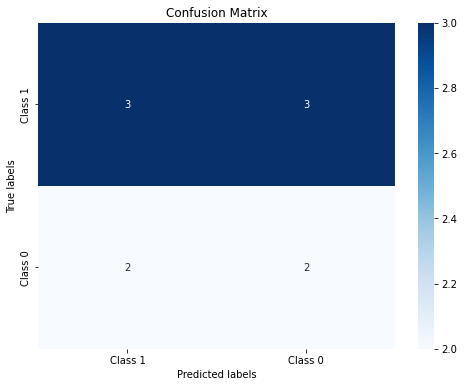

In [60]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Generate example data
y_true=[1,1,1,1,0,0,0,0,0,0]
y_pred=[0,1,0,1,1,0,0,1,0,1]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred)


In [63]:
# Generate example data
y_true=[1,1,1,1,0,0,0,0,0,0]
y_pred=[0,1,0,1,1,0,0,1,0,1]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm

array([[3, 3],
       [2, 2]], dtype=int64)

In [71]:
y_true=[1,1,1,1,0,0,0,0,0,0]
y_pred=[1,1,0,1,0,0,0,0,0,1]
cm = confusion_matrix(y_true, y_pred)

In [73]:
def plot_confusion_matrix(cm, title):
    group_names = ['TN','FP','FN','TP']

    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)    
    
    ax= sns.heatmap(cm, annot=labels, fmt="", cmap='Reds')
    ax.set_title(title);
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values ');
    plt.show()

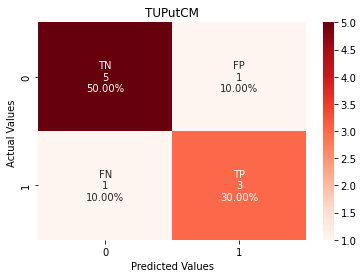

In [75]:
t='TUPutCM'
plot_confusion_matrix(cm,t)

In [ ]:
text_data = train_data.news_stemmed.values
Y_train_LSTM = train_data.Label_1day.values
Y_train_CNN = train_data.Label_5day.values
Y_train_RNN = train_data.Label_4day.values

text_val = val_data.news_stemmed.values
Y_val_LSTM = val_data.Label_1day.values
Y_val_CNN = val_data.Label_5day.values
Y_val_RNN = val_data.Label_4day.values

text_test = test_data.news_stemmed.values
Y_test_LSTM = test_data.Label_1day.values
Y_test_CNN = test_data.Label_5day.values
Y_test_RNN = test_data.Label_4day.values
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred)

## One Headline

In [41]:
rf_pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer=lambda x: x)),  
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier()) ])

In [42]:
params = {'vect__ngram_range': [(1, 1), (1, 2)],
          'vect__max_features': (10000,15000),
          'vect__min_df': (5,10),                             
          'clf__n_estimators': (100,200),
          'clf__max_depth': (15, 30,40),
          'clf__min_samples_split' : (5, 10, 15),
          'clf__min_samples_leaf' : (1, 5, 10)}

In [58]:
df_h = df[['Date','Label_5day','Top13']].copy()   
train = df_h[df_h['Date']<'20141231']
test = df_h[df_h['Date']>'20141231']
y_train = train['Label_5day']
y_test = test['Label_5day']

In [44]:
gs = GridSearchCV(estimator=rf_pipeline, param_grid=params, n_jobs=-1, cv=4)
gs_results = gs.fit(train['Top13'], y_train)

In [45]:
print(f"best parameters:\n{gs_results.best_params_}\naccuracy: {gs_results.best_score_}")

best parameters:
{'clf__max_depth': 30, 'clf__min_samples_leaf': 10, 'clf__min_samples_split': 15, 'clf__n_estimators': 100, 'vect__max_features': 10000, 'vect__min_df': 5, 'vect__ngram_range': (1, 2)}
accuracy: 0.5925459550880832


In [105]:
rf_pipe = Pipeline([    
    ('vect', CountVectorizer(analyzer=lambda x: x )),  #min_df=5, max_features=10000,ngram_range=(1,2), 
    ('tfidf', TfidfTransformer(use_idf=True)),  #, norm='l2'  use_idf=False
    ('clf', RandomForestClassifier(
                                   #random_state=1,
                                   #max_depth= 30, 
                                   #min_samples_leaf= 10, 
                                   #min_samples_split= 15,
                                   #n_estimators= 100 
                                  )) ])

In [106]:
rf_pipe.fit(train['Top13'],y_train)
prediction = rf_pipe.predict(test['Top13'])

print(classification_report(y_test, prediction))
matrix=confusion_matrix(y_test,prediction)
score=accuracy_score(y_test,prediction)
print("Accuracy:",score)

              precision    recall  f1-score   support

           0       0.57      0.86      0.69       201
           1       0.64      0.28      0.39       177

    accuracy                           0.59       378
   macro avg       0.61      0.57      0.54       378
weighted avg       0.60      0.59      0.55       378

Accuracy: 0.5873015873015873


Text(0.5, 15.0, 'Predicted')

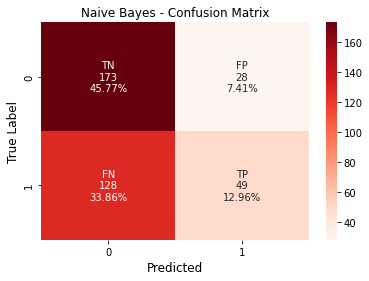

In [107]:
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
            matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                 matrix.flatten()/np.sum(matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
      zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
plt.title('Naive Bayes - Confusion Matrix')

sns.heatmap(matrix, annot=labels, fmt="", cmap='Reds')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted',fontsize=12)

## Two Headlines

In [46]:
rf_pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer=lambda x: x)),  
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier()) ])

In [47]:
params = {'vect__ngram_range': [(1, 1), (1, 2)],
          'vect__max_features': (10000,15000),
          'vect__min_df': (5,10),          
          'clf__n_estimators': (100,200),
          'clf__max_depth': (15, 30,40),
          'clf__min_samples_split' : (5, 10, 15),
          'clf__min_samples_leaf' : (1, 5, 10)}       

In [140]:
df_h = df[['Date','Label_4day','Top20','Top25']].copy()   
df_h['news'] = df_h['Top20']+df_h['Top25']
train = df_h[df_h['Date']<'20141231']
test = df_h[df_h['Date']>'20141231']
y_train = train['Label_4day']
y_test = test['Label_4day']

In [49]:
gs = GridSearchCV(estimator=rf_pipeline, param_grid=params, n_jobs=-1, cv=4)
gs_results = gs.fit(train['news'], y_train)

In [50]:
print(f"best parameters:\n{gs_results.best_params_}\naccuracy: {gs_results.best_score_}")

best parameters:
{'clf__max_depth': 30, 'clf__min_samples_leaf': 10, 'clf__min_samples_split': 15, 'clf__n_estimators': 200, 'vect__max_features': 10000, 'vect__min_df': 5, 'vect__ngram_range': (1, 1)}
accuracy: 0.5509209535449304


In [175]:
rf_pipeline = Pipeline([
    ('vect', CountVectorizer(#min_df=5, 
                             max_features=10000,
                             ngram_range=(1, 1),
                             analyzer=lambda x: x )),  
    ('tfidf', TfidfTransformer(use_idf=True)),  #, norm='l2' 
    ('clf', RandomForestClassifier(
                            random_state=1,
                                 #  max_depth= 30,
                                #   min_samples_leaf= 10,
                                 #  min_samples_split= 15, 
                                   n_estimators= 200 
                                  )) ])

In [176]:
rf_pipeline.fit(train['news'],y_train)
prediction = rf_pipeline.predict(test['news'])

print(classification_report(y_test, prediction))
matrix=confusion_matrix(y_test,prediction)
score=accuracy_score(y_test,prediction)
print("Accuracy:",score)

              precision    recall  f1-score   support

           0       0.57      0.82      0.67       202
           1       0.58      0.28      0.38       176

    accuracy                           0.57       378
   macro avg       0.57      0.55      0.52       378
weighted avg       0.57      0.57      0.53       378

Accuracy: 0.5687830687830688


Text(0.5, 15.0, 'Predicted')

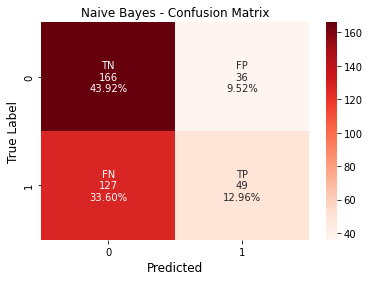

In [177]:
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
            matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                 matrix.flatten()/np.sum(matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
      zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
plt.title('Naive Bayes - Confusion Matrix')

sns.heatmap(matrix, annot=labels, fmt="", cmap='Reds')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted',fontsize=12)

## Three Headlines 

In [178]:
rf_pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer=lambda x: x)),  
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier()) ])

In [179]:
params = {'vect__ngram_range': [(1, 1), (1, 2)],
          'vect__max_features': (10000,15000),
          'vect__min_df': (5,10),                        
          'clf__n_estimators': (100,200),
          'clf__max_depth': (15, 30,40),
          'clf__min_samples_split' : (5, 10, 15),
          'clf__min_samples_leaf' : (1, 5, 10)}

In [221]:
df_h = df[['Date','Label_2day','Top1','Top6','Top16']].copy()   
df_h['news'] = df_h['Top1']+df_h['Top6']+df_h['Top16']
train = df_h[df_h['Date']<'20141231']
test = df_h[df_h['Date']>'20141231']
y_train = train['Label_2day']
y_test = test['Label_2day']

In [54]:
gs = GridSearchCV(estimator=nb_pipeline, param_grid=params, n_jobs=-1, cv=4)
gs_results = gs.fit(train['news'], y_train)

ValueError: Invalid parameter 'clf' for estimator Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function <lambda> at 0x000001BE04DA8DC0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())]). Valid parameters are: ['memory', 'steps', 'verbose'].

In [ ]:
print(f"best parameters:\n{gs_results.best_params_}\naccuracy: {gs_results.best_score_}")

In [261]:
rf_pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=1, 
                             max_features=10000, 
                             ngram_range=(1, 2), 
                             analyzer=lambda x: x )),  
    ('tfidf', TfidfTransformer(
                            use_idf=True,                             
                              )),  
    ('clf', RandomForestClassifier(random_state=1,
                               #    max_depth= 30, 
                                   min_samples_leaf= 1, 
                              #     min_samples_split= 5, 
                                   n_estimators= 200 
                                  )) ])

In [262]:
rf_pipeline.fit(train['news'],y_train)
prediction = rf_pipeline.predict(test['news'])

print(classification_report(y_test, prediction))
matrix=confusion_matrix(y_test,prediction)
score=accuracy_score(y_test,prediction)
print("Accuracy:",score)

              precision    recall  f1-score   support

           0       0.62      0.83      0.71       207
           1       0.65      0.39      0.48       171

    accuracy                           0.63       378
   macro avg       0.63      0.61      0.60       378
weighted avg       0.63      0.63      0.61       378

Accuracy: 0.626984126984127


Text(0.5, 15.0, 'Predicted')

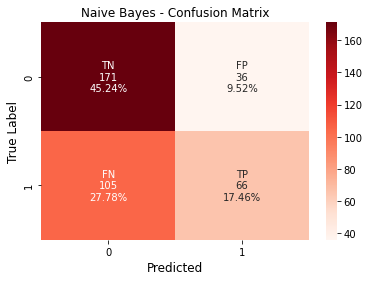

In [263]:
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
            matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                 matrix.flatten()/np.sum(matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
      zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
plt.title('Naive Bayes - Confusion Matrix')

sns.heatmap(matrix, annot=labels, fmt="", cmap='Reds')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted',fontsize=12)